# Business problem:

Companies usually have a greater focus on customer acquisition than customer. However, it can cost anywhere between five to twenty five times more to attract a new customer than retain an existing one. Increasing customer retention rates by 5% can increase profits by 25%, according to a research done by Bain & Company.

Churn is a metric that measures the no. of customers who stop doing business with a company. Through this metric, most businesses would try to understand the reason behind churn numbers and tackle those factors with reactive action plans.

But what if you could identify a customer who is likely to churn and take appropriate steps to prevent it from happening? The reasons that lead customers to the cancellation decision can be numerous, ranging from poor service quality to new competitors entering the market. Usually, there is no single reason, but a combination of factors that result to customer churn.

Although the customers have churned, their data is still available. Through machine learning we can sift through this valuable data to discover patterns and understand the combination of different factors which lead to customer churn.

Our goal in this project is to identify behavior among customers who are likely to churn. Subsequent to that we need to train a machine learning model to identify these signals from a customer before they churn. Once deployed, our model will identify customers who might churn and alert us to take necessary steps to prevent their churn.

# Take input as formatted data:train, validation and test from the data processed python file. 

# Use HyperOpt and genetic algorithms for parameter tuning

# Output the best model 

# Initialisation

In [50]:
###############################################################################
#
#Importing libraries
#
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score as R
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import chi2
import pickle
###############################################################################
#
#Notebook options
#
pd.options.display.max_columns =100
warnings.filterwarnings('ignore')
###############################################################################


In [ ]:
train = pd.read_csv(r"../Data/train.csv")
test = pd.read_csv(r"../Data/test.csv")


In [ ]:
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [ ]:
ch=pd.DataFrame(chi2(X_train, y_train)).transpose()
ch.columns=['Chi squared value','p-value']
ch['p-value'] = ch['p-value'].apply(lambda x: float(x))
to_drop = ch[ch['p-value']>0.05].index.tolist()
to_drop = [str(x) for x in to_drop]

X_train.drop(to_drop,axis=1,inplace=True)
X_test.drop(to_drop,axis=1,inplace=True)


In [ ]:
r=RandomUnderSampler()
X_train, y_train = r.fit_resample(X_train, y_train)


# Model

In [51]:
###############################################################################
#
# def build(model,X_train, X_test, y_train, y_test,c,e)
# 
# Input:
# model = the model object
# X_train, X_test = standard scaled train and test features
# y_train, y_test = response variables in train and test set
# c = Revenue lost due to churn of a singular customer
# e = Cost of focusing effort on a single to prevent his/her churn
#
# 1. Initialise variables 
# 2. Fit the model
# 3. r = recall_score
# 4. p = count of missed positive churn predictions 
# 5. Unravel the confusion matrix
# 6. Calculate F1 score
# 7. Calculate ROC score
# 8. Revenue = (Predicted & actual churn)*c -(count of missed actual positive prediction)*c - (predicted churn)*e
# 9. Send computed values to business function
#
###############################################################################

def build(model,X_train, X_test, y_train, y_test,c,e):  

    rev,p,r=0,0,0

    model.fit(X_train,y_train)
    y_pr=model.predict(X_test)

    r=round(recall_score(y_test,y_pr)*100,2)
    p=round((100-r),2)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pr).ravel()
    f1 = f1_score(y_test,y_pr)
    roc = roc_auc_score(y_test, y_pr)
    rev = tp*c -fn*c - (tp+fp)*e
    return round(r,2), round(p,2), f1, roc,rev  

In [56]:
#########################################################################################
#
# def compute(df,c,e):
# 
# Input:
# df = input dataframe  
# c = Revenue lost due to churn of a singular customer
# e = Cost of focusing effort on a single to prevent his/her chur
#
# 1. Preprocesses the data
# 2. Splits the data into training and test set; undersamples the overrepresented class in training set 
# 3. Prepares models and calculates parameters
# 4. Collates all the data into a mod dataframe
# 5. Return the comparison database
#
#########################################################################################

def compute(X_train,y_train,X_test,y_test, *var):
    
    c=var[0]
    e=var[1]
    #X,y=preprocess(df)
    #X_train, X_test, y_train, y_test = 

    svm = SVC()
    b=BernoulliNB()
    gbc=GradientBoostingClassifier()
    ada=AdaBoostClassifier()
    lr=LogisticRegression()
    rf=RandomForestClassifier()   

    pred_b,misd_b,f1_b,roc_b,rev_b=build(b,X_train, X_test, y_train, y_test,c,e)
    pred_knn,misd_knn,f1_knn,roc_knn,rev_knn=build(gbc,X_train, X_test, y_train, y_test,c,e)
    pred_ada,misd_ada,f1_ada,roc_ada,rev_ada=build(ada,X_train, X_test, y_train, y_test,c,e)
    pred_lr,misd_lr,f1_lr,roc_lr,rev_lr=build(lr,X_train, X_test, y_train, y_test,c,e)
    pred_svm,misd_svm,f1_svm,roc_svm,rev_svm=build(svm,X_train, X_test, y_train, y_test,c,e)
    pred_rf,misd_rf,f1_rf,roc_rf,rev_rf=build(rf,X_train, X_test, y_train, y_test,c,e)

    rev = [rev_svm,rev_b,rev_knn,rev_lr,rev_rf,rev_ada]
    misd= [misd_svm,misd_b,misd_knn,misd_lr,misd_rf,misd_ada]
    pred= [pred_svm,pred_b,pred_knn,pred_lr,pred_rf,pred_ada]
    f1s= [f1_svm,f1_b,f1_knn,f1_lr,f1_rf,f1_ada]
    rocs= [roc_svm,roc_b,roc_knn,roc_lr,roc_rf,roc_ada]
    mod = ["Support Vector Machine", "Naive Bayes","Gradient Boosting Classifier","Logistic regression","Random Forest","AdaBoost Classifier"]
    model = [svm,b,gbc,lr,rf,ada]

    mod = pd.DataFrame({"Revenue saved":rev,"Predicted(True positive)":pred,"Missed(False negative)":misd,"F1 score":f1s, "ROC_AUC":rocs,"Model":model}, index=mod)
    mod.sort_values(["Revenue saved"], ascending=False,inplace=True)
    
    return mod

# Business implication

In [57]:
#########################################################################################
#
# def business(mod,c,e):
# Input:
# mod = model details dataframe
# c = Revenue lost due to churn of a singular customer
# e = Cost of focusing effort on a single to prevent his/her chur
#  
# 1. lost = Total revenue lost due to churn = (Total reponses=1, i.e. churn) * (cost of churn)
# 2. best = best model as per revenue
# 3. Initialize some variables
# 4. Draw >30 samples of size 50% of df
# 5. x = Selecting random set of 50% customers
# 6. saved_churn = Count of churn predicted by the current sample * cost of churn
# 7. cost_of_effort = Total expenditure by focusing effort on random 50% of df
# 8. money_that_could_have_been_saved = difference between focusing effort on random 50% of the population and return on it by saving churn
# 9. cost_saved_by_model = revenue loss prevented by predicting churn using our model
# 10. avg_rev_lost = averages the money that could have been saved over all the 50 samples drawn each time
# 11. avg_money_saved = cost saved by our model + money that could have been saved
# 12. cost = averages the money that could have been saved over all sample draws
# 13. gained_rev = averages the money saved by our model as compared to random sampling over all sample draws
# 14. Print summary
#
#########################################################################################

def business(df,y,mod,c,e):

    lb=LabelBinarizer()
    lost=lb.fit_transform(y).sum()*c 

    best=mod.head(1)

    avg_rev_lost=[]
    avg_money_saved=[]

    for i in range(1,31):
        
        var_churn=0.5
        x = random.randint(df.shape[0], size=(round(df.shape[0]*var_churn)))     
        saved_churn = (lb.fit_transform(df.Churn.iloc[x])).sum()*c  
        cost_of_effort = x.shape[0]*e
        
        money_that_could_have_been_saved = cost_of_effort-saved_churn
        cost_saved_by_model=best.iloc[0,0]

        avg_rev_lost.append(money_that_could_have_been_saved)
        avg_money_saved.append(cost_saved_by_model+money_that_could_have_been_saved)

    cost = pd.DataFrame(avg_rev_lost).mean()
    gained_rev = pd.DataFrame(avg_money_saved).mean()

    print(f"Lost revenue if we do not prevent churn = Rs.{lost} \n") 
    print(f"Assumed cost of losing a customer: Rs.{c} \nAssumed cost of effort to prevent churn: Rs.{e} \n")
    print(f"Percentage of customers predicted by '{best.index[0]}' who were going to churn: {best.iloc[0,1]}%")
    print(f"Percentage of customers missed by '{best.index[0]}' who were going to churn: {best.iloc[0,2]}%")
    print("Revenue saved by preventing churn with our model as compared to no model = Rs", best.iloc[0,0])
    print(f"\n\nTotal expenditure for preventing churn on random {var_churn*100}% of customers: Rs.{cost_of_effort}")
    print(f"Extra cost to prevent churn within random {var_churn*100}% of the customers = Rs.{round(cost[0])}")
    print(f"Our '{best.index[0]}' model saves us Rs.{round(gained_rev[0])} on an average compared to a random selection of 50% customers")
    return best

In [58]:
from sklearn.metrics import confusion_matrix

In [61]:
if __name__=="__main__":

    c = input("Enter the revenue lost due to churn of a single customer")
    e = input("Cost of focusing effort on a customer to prevent his/her churn")
    c = 0 if c=='' else int(c)
    e = 0 if e=='' else int(e)
    if c>0 and e>0:
        var = [c,e]
    else: 
        var=[5000,1500]
    mod=compute(X_train,y_train,X_test,y_test,*var)
    #business(df,y,mod,*var)

In [62]:
mod

,Revenue saved,Predicted(True positive),Missed(False negative),F1 score,ROC_AUC,Model
Naive Bayes,12000,78.76,21.24,0.544343,0.718572,BernoulliNB()
AdaBoost Classifier,-176500,59.00,41.00,0.606061,0.738443,"(DecisionTreeClassifier(max_depth=1, random_st..."
Logistic regression,-244000,57.23,42.77,0.583459,0.724453,LogisticRegression()
Gradient Boosting Classifier,-248500,56.34,43.66,0.589506,0.726571,([DecisionTreeRegressor(criterion='friedman_ms...
Random Forest,-349000,52.80,47.20,0.563780,0.709339,"(DecisionTreeClassifier(max_features='auto', r..."
Support Vector Machine,-355000,52.80,47.20,0.560250,0.707470,SVC()


In [37]:
from sklearn.tree import DecisionTreeClassifier

g=DecisionTreeClassifier()
g.fit(X_train, y_train)
path = g.cost_complexity_pruning_path(X_train, y_train)
alpha=path.ccp_alphas.tolist()
trainscores=[]
testscores=[]

for i in alpha:
    g=DecisionTreeClassifier(ccp_alpha=i)
    g.fit(X_train,y_train)
    yptrain=g.predict(X_train)
    yptest=g.predict(X_test)

    trainscores.append(accuracy_score(y_train,yptrain))
    testscores.append(accuracy_score(y_test,yptest))

    


c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


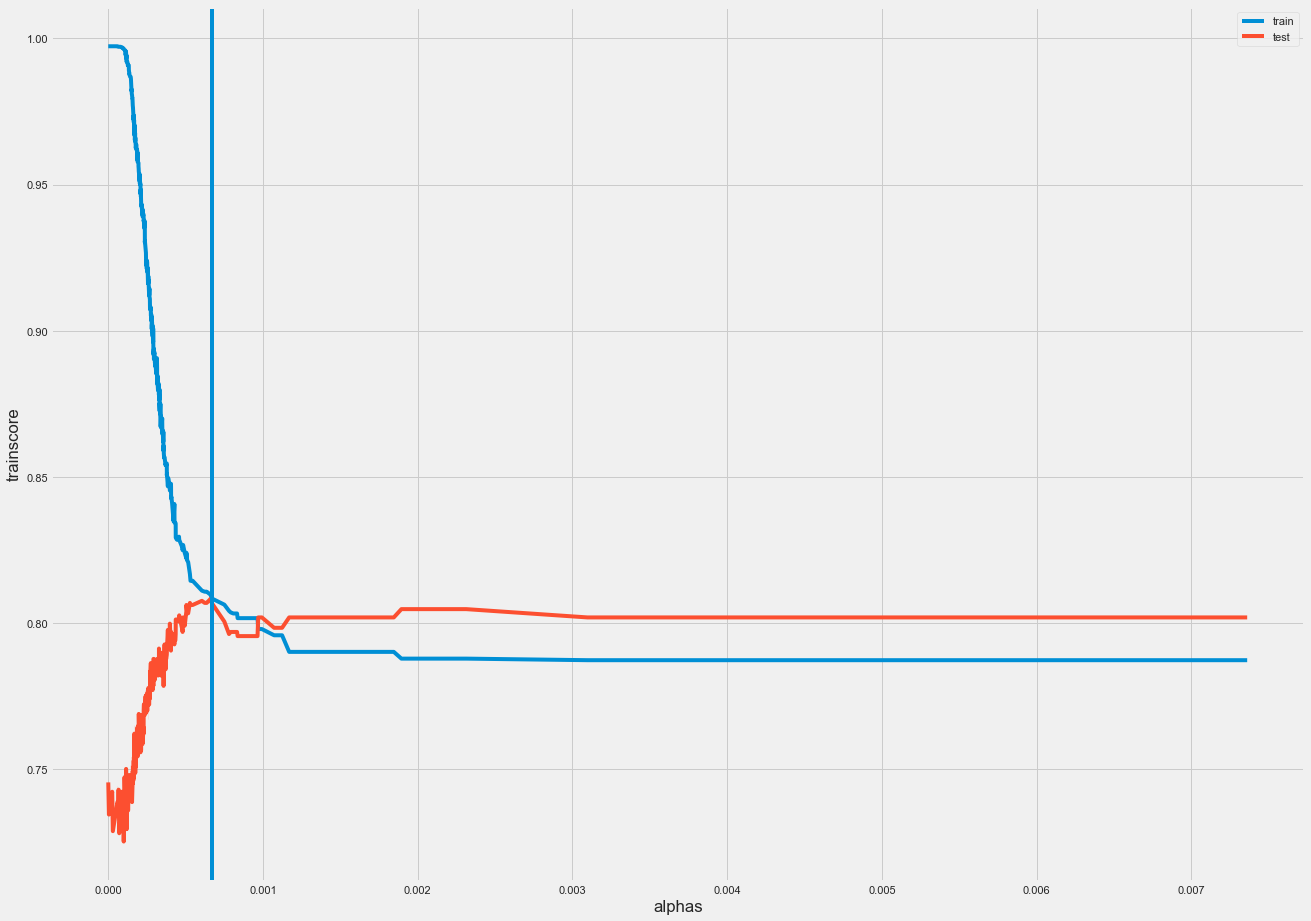

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

d=pd.DataFrame({'alphas':alpha, 'trainscore':trainscores, 'testscore':testscores})
d=d[d.alphas<0.01
]
plt.figure(figsize=(20,15))
sns.set()
plt.style.use('fivethirtyeight')
sns.lineplot(d.alphas, d.trainscore, label='train')
sns.lineplot(d.alphas, d.testscore, label='test')
plt.axvline(0.00067)